In [1]:
import os, random, glob, pickle, collections, math
import numpy as np
import pandas as pd
import ujson as json
from PIL import Image
import gc
import glob

import utils; reload(utils)
from utils import *

from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing import image
from keras import backend as K
K.set_image_dim_ordering('tf')

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
TRAIN_DIR = '../data/fish/train-all/'
TEST_DIR =  '../data/fish/test/' 
CHECKPOINT_DIR = './checkpoints/checkpoint05/'
LOG_DIR = './logs/log05/'
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
CONF_THRESH = 0.8
ROWS = 360 # 224
COLS = 680 # 224
BATCHSIZE = 32 #64 #256 #64
LEARNINGRATE = 1e-4
BG_THRESH_HI = 0.3
BG_THRESH_LO = 0.1
learn_round = 2
p=16

def load_img(path, bbox, target_size=None):
    img = Image.open(path)
    img = img.convert('RGB')
    cropped = img.crop((bbox[0],bbox[1],bbox[2],bbox[3]))
    if target_size:
        cropped = cropped.resize((target_size[1], target_size[0]))
    return cropped

def load_img_full(path, target_size=None):
    img = Image.open(path)
    img = img.convert('RGB')
    if target_size:
        img = img.resize((target_size[1], target_size[0]))
    return img

def preprocess_input(x):
    #resnet50 image preprocessing
    # 'RGB'->'BGR'
    x = x[:, :, ::-1]
    x[:, :, 0] -= 103.939
    x[:, :, 1] -= 116.779
    x[:, :, 2] -= 123.68
    return x

In [3]:
file_name = 'GTbbox_ResizedLrg_df.pickle'
if os.path.exists('../data/'+file_name):
    print ('Loading from file '+file_name)
    GTbbox_df = pd.read_pickle('../data/'+file_name)
else:
    print ('Generating file '+file_name)       
    GTbbox_df = pd.DataFrame(columns=['image_folder', 'image_file','crop_index','crop_class','xmin','ymin','xmax','ymax'])  

    crop_classes=FISH_CLASSES[:]
    crop_classes.remove('NoF')

    for c in crop_classes:
        print(c)
        j = json.load(open('../data/fish/annos1/{}.json'.format(c), 'r'))
        for l in j: 
            filename = l["filename"]
            head, image_file = os.path.split(filename)
            basename, file_extension = os.path.splitext(image_file) 
            image = Image.open(TRAIN_DIR+c+'/'+image_file)
            width_image, height_image = image.size
            for i in range(len(l["annotations"])):
                a = l["annotations"][i]
                xmin = (a["x"])
                ymin = (a["y"])
                width = (a["width"])
                height = (a["height"])
                delta_width = p/(COLS-2*p)*width
                delta_height = p/(ROWS-2*p)*height
                xmin_expand = xmin-delta_width
                ymin_expand = ymin-delta_height
                xmax_expand = xmin+width+delta_width
                ymax_expand = ymin+height+delta_height
                assert max(xmin_expand,0)<min(xmax_expand,width_image)
                assert max(ymin_expand,0)<min(ymax_expand,height_image)
                GTbbox_df.loc[len(GTbbox_df)]=[c, image_file,i,a["class"],max(xmin_expand,0),max(ymin_expand,0),min(xmax_expand,width_image),min(ymax_expand,height_image)]
                #if a["class"] != c: print(GTbbox_df.tail(1))
    GTbbox_df['area'] = (GTbbox_df['xmax']-GTbbox_df['xmin'])*(GTbbox_df['ymax']-GTbbox_df['ymin'])
    GTbbox_df = GTbbox_df.loc[GTbbox_df.reset_index().groupby(['image_file'])['area'].idxmax()].reset_index(drop=True)

    for c in FISH_CLASSES:
        print(c)
        for f in os.listdir(os.path.join(TRAIN_DIR, c)):
            if f not in GTbbox_df.image_file.values:
                GTbbox_df.loc[len(GTbbox_df)] = [c, f, 0.0, c, 0., 0., 0., 0., 0.]  
            else:
                image = Image.open(TRAIN_DIR+c+'/'+f)
                imgid = GTbbox_df['image_file']==f
                GTbbox_df.ix[imgid, 'xmin'] = GTbbox_df.ix[imgid, 'xmin'] * (float(COLS)/image.size[0])
                GTbbox_df.ix[imgid, 'xmax'] = GTbbox_df.ix[imgid, 'xmax'] * (float(COLS)/image.size[0])
                GTbbox_df.ix[imgid, 'ymin'] = GTbbox_df.ix[imgid, 'ymin'] * (float(ROWS)/image.size[1])
                GTbbox_df.ix[imgid, 'ymax'] = GTbbox_df.ix[imgid, 'ymax'] * (float(ROWS)/image.size[1])
    GTbbox_df.drop(['area'], axis=1, inplace=True)
    GTbbox_df.to_pickle('../data/'+file_name)

Generating file GTbbox_ResizedLrg_df.pickle
ALB
BET
DOL
LAG
OTHER
SHARK
YFT
NoF
ALB
BET
DOL
LAG
OTHER
SHARK
YFT


In [4]:

GTbbox_df.head(3)

,image_folder,image_file,crop_index,crop_class,xmin,ymin,xmax,ymax
0,ALB,img_00003.jpg,3.0,ALB,154.59375,61.000000,341.59375,203.500000
1,YFT,img_00004.jpg,0.0,YFT,295.90625,171.868583,504.68750,269.075975
2,ALB,img_00010.jpg,0.0,ALB,345.84375,211.000000,396.31250,306.000000


In [5]:
def train_generator(datagen, df):
    while 1:
        batch_x = np.zeros((BATCHSIZE, ROWS, COLS, 3), dtype=K.floatx())
        batch_y1 = np.zeros((BATCHSIZE, len(FISH_CLASSES)), dtype=K.floatx())
        batch_y2 = np.zeros((BATCHSIZE, 4), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_perClass, replace=False),:]
        batch_df = df.groupby('crop_class', as_index=True).apply(fn)
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = os.path.join(row[0], row[1])
            fish = row[0]
            bbox =  [row[6]-row[4], row[7]-row[5], row[4], row[5]] #row[4:8]
            cropped = load_img_full(TRAIN_DIR+image_file,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            # x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            batch_y1[i,FISH_CLASSES.index(fish)] = 1
            batch_y2[i,:] = row[6]-row[4], row[7]-row[5], row[4], row[5] #bbox
            i += 1
        yield (batch_x, [batch_y1, batch_y2])

def test_generator(datagen, df):
    while 1:
        batch_x = np.zeros((BATCHSIZE, ROWS, COLS, 3), dtype=K.floatx())
        #batch_y = np.zeros((BATCHSIZE, len(FISH_CLASSES)), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_perClass, replace=False),:]
        batch_df = df.groupby('crop_class', as_index=True).apply(fn)
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = row[1]
            fish = row[0]
            bbox =  [row[6]-row[4], row[7]-row[5], row[4], row[5]] #row[4:8]
            image = load_img_full(TEST_DIR+image_file,target_size=(ROWS,COLS))
            x = np.asarray(image, dtype=K.floatx())
            # x = datagen.random_transform(x)
            x = preprocess_input(x)
            batch_x[i] = x
            # batch_y[i,FISH_CLASSES.index(fish)] = 1
            i += 1
        yield (batch_x)
        
train_datagen = ImageDataGenerator(
    rotation_range=180,
    shear_range=0.01,
    zoom_range=0.01,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
    )

In [6]:
# Read in the validation set
df_valid = pd.read_csv('../image_validation_set.csv')
valid_set = df_valid[df_valid['Validation']==1].file_name.tolist()
#train data prepare
# train_df, valid_df = train_test_split(GTbbox_df, test_size = 0.2, random_state=1986, stratify=GTbbox_df['crop_class'])
train_df = GTbbox_df[~GTbbox_df['image_file'].isin(valid_set)]
valid_df = GTbbox_df[GTbbox_df['image_file'].isin(valid_set)]

nb_perClass = int(BATCHSIZE / len(FISH_CLASSES)) 
samples_per_epoch=BATCHSIZE*math.ceil(train_df.groupby('crop_class').size()['ALB']/nb_perClass)

In [7]:
def generator_test(gen, df, DIR):
        batch_x = np.zeros((BATCHSIZE, ROWS, COLS, 3), dtype=K.floatx())
        batch_y = np.zeros((BATCHSIZE, len(FISH_CLASSES)), dtype=K.floatx())
        fn = lambda obj: obj.loc[np.random.choice(obj.index, size=nb_perClass, replace=False),:]
        batch_df = df.groupby('crop_class', as_index=True).apply(fn)
        i = 0
        for index,row in batch_df.iterrows():
            row = row.tolist()
            image_file = os.path.join(row[0], row[1])
            fish = row[0]
            bbox =  [row[6]-row[4], row[7]-row[5], row[4], row[5]] #row[4:8]
            image = load_img_full(TRAIN_DIR+image_file,target_size=(ROWS,COLS))
        #return cropped
        img = np.expand_dims(image,0)
        #aug_iter = gen.flow(img)
        #aug_imgs = [next(aug_iter)[0].astype(np.uint8) for i in range(8)]
        return image #aug_imgs, image

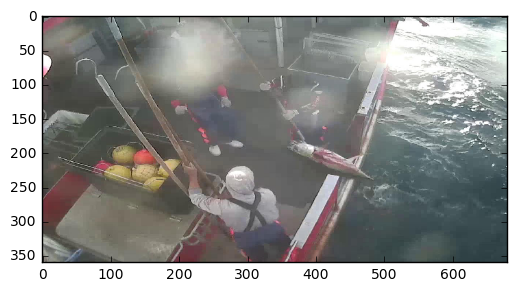

In [8]:
# aug_imgs, image = generator_test(train_datagen, df=train_df, DIR = TRAIN_DIR)
image = generator_test(train_datagen, df=train_df, DIR = TRAIN_DIR)

# Augmented data
plt.imshow(image)

In [9]:
## Augmented data
# plots(aug_imgs, (20,7), 2)

In [10]:
valid_df[:2]

,image_folder,image_file,crop_index,crop_class,xmin,ymin,xmax,ymax
0,ALB,img_00003.jpg,3.0,ALB,154.59375,61.00,341.59375,203.50
13,ALB,img_00037.jpg,0.0,ALB,154.59375,133.44,203.46875,209.28


In [11]:
# validation_data (valid_x,valid_y)
df_1 = valid_df
l = valid_df.groupby('crop_class').size()
valid_x = np.zeros((valid_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
valid_y1 = np.zeros((valid_df.shape[0], len(FISH_CLASSES)), dtype=K.floatx())
valid_y2 = np.zeros((valid_df.shape[0], 4), dtype=K.floatx())
i = 0
for index,row in valid_df.iterrows():
    row = row.tolist()
    image_file = os.path.join(row[0], row[1])
    fish = row[0]
    cropped = load_img_full(TRAIN_DIR+image_file,target_size=(ROWS,COLS))
    x = np.asarray(cropped, dtype=K.floatx())
    x = preprocess_input(x)
    valid_x[i] = x
    valid_y1[i,FISH_CLASSES.index(fish)] = 1
    valid_y2[i,:] = row[6]-row[4], row[7]-row[5], row[4], row[5]
    i += 1

In [12]:
#callbacks
early_stopping = EarlyStopping(monitor='val_class_loss', min_delta=0, patience=10, verbose=1, mode='auto')        
model_checkpoint = ModelCheckpoint(filepath=CHECKPOINT_DIR+'weights.{epoch:03d}-{val_class_loss:.4f}-{val_bb_loss:.1f}.hdf5', monitor='val_class_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
learningrate_schedule = ReduceLROnPlateau(monitor='val_class_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)
# tensorboard = TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=False, write_images=True)

In [ ]:
#Resnet50
#top layer training

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x1 = GlobalAveragePooling2D()(x)
x1 = Dropout(0.5)(x1)
x1 = Dense(256, init='glorot_normal')(x1)
x1 = LeakyReLU(alpha=0.33)(x1)
x1 = Dropout(0.5)(x1)
y_predictions = Dense(len(FISH_CLASSES), name='class', init='glorot_normal', activation='softmax')(x1)
#x = Dropout(p/2)(x)
#x = Flatten()(x)
#x = Dense(1024, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(p/2)(x)
#x = Dense(1024, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(p/2)(x)
x2 = GlobalAveragePooling2D()(x)
x2 = Dropout(0.25)(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.25)(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.25)(x2)
y_bb = Dense(4, name='bb')(x2)


model = Model(input=base_model.input, output=[y_predictions, y_bb]) 

# model = Model(input=base_model.input, output=[y_predictions]) 
# model.summary()
# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=LEARNINGRATE)
# model.compile(optimizer=optimizer, metrics=['accuracy'], loss='categorical_crossentropy')

model.compile(optimizer=optimizer, metrics=['accuracy'], loss=['categorical_crossentropy', 'mse'], 
              loss_weights=[1, .0001])

# model.compile(optimizer=optimizer, metrics=['accuracy'], loss=['categorical_crossentropy'], loss_weights=[1])

(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)


In [ ]:
# train the model on the new data for a few epochs
# model.fit_generator(train_generator(datagen=train_datagen, df=train_df), samples_per_epoch=samples_per_epoch, nb_epoch=30, verbose=1,
#                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule],  # , tensorboard
#                    validation_data=(valid_x,valid_y), nb_worker=3, pickle_safe=True)

model.fit_generator(train_generator(datagen=train_datagen, df=train_df), samples_per_epoch=samples_per_epoch, nb_epoch=30, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule],  # , tensorboard
                    validation_data=(valid_x,[valid_y1, valid_y2]), nb_worker=3, pickle_safe=True) 

Epoch 1/30
11360/11360 [==============================] - 2732s - loss: 4.1394 - class_loss: 1.4505 - bb_loss: 26888.6275 - class_acc: 0.4916 - bb_acc: 0.4412 - val_loss: 4.2834 - val_class_loss: 1.5049 - val_bb_loss: 27784.9428 - val_class_acc: 0.3444 - val_bb_acc: 0.4443
Epoch 2/30
11328/11360 [============================>.] - ETA: 7s - loss: 3.3332 - class_loss: 0.8989 - bb_loss: 24342.8659 - class_acc: 0.6833 - bb_acc: 0.4568 

In [ ]:
# Resnet50
# fine tuning
del model
gc.collect()

In [ ]:
import glob
BATCHSIZE = 16
start_layer = 38
files = glob.glob(CHECKPOINT_DIR+'*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
# model = load_model(files[index])
model = load_model('./checkpoints/checkpoint04/weights.005-1.0353-6722.7.hdf5')
# model = load_model('./checkpoints/checkpoint04/weights.009-0.9400-2004.7.hdf5')

for layer in model.layers[:start_layer]:
    layer.trainable = False
for layer in model.layers[start_layer:]:
    layer.trainable = True

optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, metrics=['accuracy'], loss=['categorical_crossentropy', 'mse'], loss_weights=[1, .00001])
model.fit_generator(train_generator(datagen=train_datagen, df=train_df), samples_per_epoch=samples_per_epoch, nb_epoch=30, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule],  # , tensorboard
                    validation_data=(valid_x,[valid_y1, valid_y2]), nb_worker=3, pickle_safe=True) 

In [ ]:
#resume training
files = glob.glob(CHECKPOINT_DIR+'*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])
model.fit_generator(train_generator(datagen=train_datagen, df=train_df), samples_per_epoch=samples_per_epoch, nb_epoch=12, verbose=1,
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule], # , tensorboard
                    validation_data=(valid_x,valid_y), nb_worker=1, pickle_safe=True)

In [ ]:
GTbbox_df[:2]

In [ ]:
# Load up YOLO bounding boxes for each class
import glob
all_files = glob.glob(os.path.join('../yolo_coords', "*.txt"))
allFiles = [f for f in all_files if 'FISH' in f]
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=None, sep = " ", names = ['fname', 'proba', 'x0', 'y0', 'x1', 'y1'])
    df['class'] = file_.split('_')[-1].split('.')[0]
    list_.append(df)
yolo_frame = pd.concat(list_)
yolo_frame = yolo_frame[yolo_frame['proba']>0.5]
yolo_frame[:2]

In [ ]:
file_name = 'GTbbox_test_df.pickle'
if False: #os.path.exists('../data/'+file_name):
    print ('Loading from file '+file_name)
    GTbbox_test_df = pd.read_pickle('../data/'+file_name)
else:
    print ('Generating file '+file_name)       
    GTbbox_test_df = pd.DataFrame(columns=['image_folder', 'image_file','crop_index','crop_class','xmin','ymin','xmax','ymax'])  
    iddict = {}
    for c in ['test']:
        print(c)
        for l in range(yolo_frame.shape[0]): 
            image_file, proba, xmin, ymin, xmax, ymax, fish_class = yolo_frame.iloc[l].values.tolist()    
            if image_file in iddict:
                iddict[image_file] += 1
            else:
                iddict[image_file] = 0
            image = Image.open(TEST_DIR+c+'/'+image_file+'.jpg')
            width_image, height_image = image.size
            width = xmax - xmin
            height = ymax - ymin
            delta_width = p/(COLS-2*p)*width
            delta_height = p/(ROWS-2*p)*height
            xmin_expand = xmin-delta_width
            ymin_expand = ymin-delta_height
            xmax_expand = xmin+width+delta_width
            ymax_expand = ymin+height+delta_height
            assert max(xmin_expand,0)<min(xmax_expand,width_image)
            assert max(ymin_expand,0)<min(ymax_expand,height_image)
            GTbbox_test_df.loc[len(GTbbox_test_df)] = [c, image_file+'.jpg',iddict[image_file],fish_class,max(xmin_expand,0),max(ymin_expand,0),min(xmax_expand,width_image),min(ymax_expand,height_image)]                    
    GTbbox_test_df = GTbbox_test_df.sort(['image_file','crop_index']).reset_index(drop=True)
    GTbbox_test_df.to_pickle('../data/'+file_name)

In [ ]:
#image_file, proba, x0, y0, x1, y1, fish_class = yolo_frame.iloc[0].values.tolist()    
#image = Image.open(TEST_DIR+c+'/'+image_file+'.jpg')
#image
aug_imgs, cropped = generator_test(train_datagen, df=GTbbox_test_df, DIR = '../data/fish/')
# Augmented data
plt.imshow(cropped)

In [ ]:
# Augmented data
plots(aug_imgs, (20,7), 2)

In [ ]:
#del model
gc.collect()

In [ ]:
import glob
files = glob.glob(CHECKPOINT_DIR+'*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
test_model = load_model(files[index])
test_model_name = files[index].split('/')[-2][-1:]+'_'+files[index].split('/')[-1]

In [ ]:
GTbbox_test_df.head(3)

In [ ]:
def test_generator(df, datagen = None, batch_size = BATCHSIZE):
    n = df.shape[0]
    batch_index = 0
    while 1:
        current_index = batch_index * batch_size
        if n >= current_index + batch_size:
            current_batch_size = batch_size
            batch_index += 1    
        else:
            current_batch_size = n - current_index
            batch_index = 0        
        batch_df = df[current_index:current_index+current_batch_size]
        batch_x = np.zeros((batch_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
        i = 0
        for index,row in batch_df.iterrows():
            image_file = row['image_file']
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            if datagen is not None: x = datagen.random_transform(x)            
            x = preprocess_input(x)
            batch_x[i] = x
            i += 1
        if batch_index%50 == 0: print(batch_index)
        yield(batch_x)

In [ ]:
test_preds = test_model.predict_generator(test_generator(df=GTbbox_test_df, datagen = train_datagen), 
                                        # samples_per_epoch=samples_per_epoch,
                                         val_samples=GTbbox_test_df.shape[0])#, 
                #nb_worker=1, pickle_safe=False) #

In [ ]:
GTbbox_test_df.image_file[:5]

In [ ]:
columns = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
yolo_pred_df = pd.DataFrame(test_preds, columns=columns)
yolo_pred_df['image_file'] = GTbbox_test_df.image_file
yolo_pred_df.shape

In [ ]:
yolo_pred_df.groupby(['image_file']).mean().shape

In [ ]:
import shutil, csv, time
timestr = time.strftime("%Y%m%d")
full = False
if full:
    subm_name = '../sub/subm_full_resnet_annos_' + timestr + '.csv' #'.csv.gz'
else:
    subm_name = '../sub/subm_part_resnet_annos_' + timestr + '.csv' #'.csv.gz'

In [ ]:
yolo_pred_df.to_csv(subm_name, index=False)#, compression='gzip')
FileLink(subm_name)